# Project 5 Report
#### Ben Raivel

In [1]:
%load_ext autoreload
import pandas as pd
import HashTable as ht
import serial
import multitasking
import multiprocessing
import shutil
import time
import matplotlib.pyplot as plt
import os

files = ['rc/reddit_comments_2008.txt', 'rc/reddit_comments_2009.txt', 'rc/reddit_comments_2010.txt', 
                'rc/reddit_comments_2011.txt', 'rc/reddit_comments_2012.txt', 'rc/reddit_comments_2013.txt',
                'rc/reddit_comments_2014.txt', 'rc/reddit_comments_2015.txt']

years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

### Multiprocessing
Below is code to count words across all files into a list of pandas DataFrames, one per input file (year), with columns for 'val' (raw count of word), 'key' (word), and 'freq' (frequency of word)

In [ ]:
# list to hold pandas df for each year
multi_df_list = []

# loop over list of file names
for f in files:

    # create a 'parent' hashtable
    multi_table = ht.HashTable()

    # open file
    file = open(f, 'r')

    # create a generator to iterate over 100,000 line blocks of file
    block_gen = multitasking.gen_block(file)

    # create a processing pool
    pool = multiprocessing.Pool()

    # non-blocking map of count words function onto generator
    sub_tables = pool.imap(multitasking.m_count_words, block_gen)

    # for each table returned by pool
    for t in sub_tables:

        # combine with the main table
        multi_table.combine(t)

    # convert hash table to dataframe and return
    multi_df_list.append(multi_table.to_df())


In [ ]:
for i in range(len(multi_df_list)):

    print('Top 10 words {year:d}'.format(year = years[i]))
    
    print(multi_df_list[i].head(10))

    print('\n')

### Performance Comparison
For the performance comparison I tracked the size of hashtables used to count words in one of the files over time. I used the 2008 files
#### Serial Code

In [3]:
try:
    shutil.rmtree('serial_logs')
except:
    pass
os.mkdir('serial_logs')

# create a 'parent' hashtable
test_table = ht.HashTable(log_folder='serial_logs')

# open file
serial.s_count_words(files[0], test_table)

#### Multiprocessing Code

In [3]:
try:
    shutil.rmtree('multi_logs')
except:
    pass
os.mkdir('multi_logs')

# create a 'parent' hashtable
test_table = ht.HashTable(log_folder='multi_logs')

# open file
file = open(files[0], 'r')

# create a generator to iterate over 100,000 line blocks of file
block_gen = multitasking.gen_block(file, time.time(), 'multi_logs')

# create a processing pool
pool = multiprocessing.Pool()

# non-blocking map of count words function onto generator
sub_tables = pool.imap(multitasking.m_count_words, block_gen)

# for each table returned by pool
for t in sub_tables:

    # combine with the main table
    test_table.combine(t)

#### Plots
Generate a plot of words counted per process for multiprocessing and serial code. For multiprocessing, the four (on my machine) worker processes count words in 100,000 line blocks, then merge them into the parent processes' HashTable. For serial, a single table is used to count the whole file.

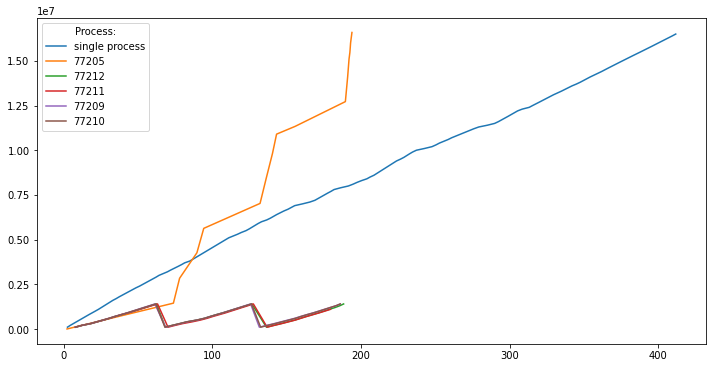

In [13]:
fig, axes = plt.subplots(1,1, figsize = (12,6))

serial_df = pd.read_csv('serial_logs/76640_log.csv')

axes.plot(serial_df.get('time'), serial_df.get('n_total'), label = 'single process')

times = []
sizes = []
names = []

log_files = os.scandir('multi_logs')

for lf in log_files:

    df = pd.read_csv(lf)

    times.append(df.get('time'))
    sizes.append(df.get('n_total'))
    names.append(lf.name.split('_')[0])

for i in range(len(times)):

    axes.plot(times[i], sizes[i], label = names[i])

axes.legend(title = 'Process:')


plt.show()

#### Discussion
Based on the plot, multithreading provides a slightly-better-than 50% reduction in runtime. Comparing the slopes of the single process vs the worker processes for multi-processing it is also evident that the single process performs better than any of the workers individually. This makes sense when you consider that my computer doesn't really have four seperate cores, but rather passes off two cores as four (with some improvements in performance) through some trickery called 'hyper-threading.'